In [1]:
import sys
sys.path.append('..')

import casadi as ca
import matplotlib.pyplot as plt
from Helpers.Helpers import *
from Controllers.NMPC import *
from Controllers.ILQGController import *

In [1]:
def optimizationofmpcproblem(dt,Horizon,w1,w2,r,end,estimate_now):
        # State variables: x (cart position), x_dot, theta (pendulum angle), theta_dot
    theta = ca.SX.sym("theta",2)
    omega = ca.SX.sym("omega",2)
    tau = ca.SX.sym("tau",2)
    state = ca.vertcat(theta,omega,tau)

    # Control input: Force applied to the cart
    u = ca.SX.sym("u",2)
    control = ca.vertcat(u)

    # Equations of motion (nonlinear dynamics)
    cos_elbow = ca.cos(theta[1])
    sin_elbow = ca.sin(theta[1])
    DetM = a1*a3-a3*a3-a2*a2*cos_elbow*cos_elbow
    Minv = np.array([[a3,-a3-a2*cos_elbow],
                [-a3-a2*cos_elbow,a1+2*a2*cos_elbow]])/DetM


    C = ca.SX(np.array([-omega[1]*(2*omega[0]+omega[1])*a2*sin_elbow,omega[0]*omega[0]*a2*sin_elbow]))

    Bdyn = ca.SX(np.array([[0.05,0.025],[0.025,0.05]]))  
    #Bdyn = ca.SX(np.array([[0.74,0.1],[0.1,0.82]]))           
    jerk = Minv @ (tau-C-Bdyn@omega)
    taudot = (u-tau)/.06
    xdot = ca.vertcat(omega,jerk,taudot)

    # CasADi function for system dynamics
    f = ca.Function("f", [state, control], [xdot])

    # Define optimization variables
    opti = ca.Opti()
    X = opti.variable(6, Horizon )  # State trajectory
    U = opti.variable(2, Horizon-1)  # Control inputs

    # Initial and target states
    X0 = opti.parameter(6)
    X_targ = np.array([end[0],end[1],0, 0,0,0])  

    # Objective function and constraints
    cost = 0
    for k in range(Horizon-1):
        x_k = X[:, k]
        u_k = U[:, k]
        cost += r*ca.sumsqr(u_k)  # Quadratic cost
        
        # System dynamics constraint using Euler discretization
        x_next = X[:, k] + dt * f(x_k, u_k)
        opti.subject_to(X[:, k + 1] == x_next)

    # Final state cost
    cost += w1 * ca.sumsqr(X[:2, -1] - X_targ[:2])
    cost += w2*ca.sumsqr(X[2:4, -1] - X_targ[2:4])

    opti.minimize(cost)

    # Initial condition constraint
    opti.subject_to(X[:, 0] == X0)

    # Solver setup
    opts = {
    "print_time": 0,
    "ipopt.hessian_approximation": "exact",
    "ipopt.tol": 1e-8,                      # Decrease tolerance for better precision
    "ipopt.acceptable_tol": 1e-8,           # More stringent acceptable tolerance
    "ipopt.max_iter": 5000,                 # Increase max iterations
    "ipopt.constr_viol_tol": 1e-6,          # Constraint violation tolerance
    "ipopt.dual_inf_tol": 1e-6,             # Dual infeasibility tolerance
    "ipopt.compl_inf_tol": 1e-6             # Complementarity tolerance
    }
    opti.solver("ipopt", opts)

    opti.solver("ipopt",opts)
    opti.set_value(X0, estimate_now)
    sol = opti.solve()
    return sol,U,f

# Discretization parameters
def MPC(Duration,start,end,w1,w2,r,Horizon = 20,dt = 0.005):


    
    end= newton(newtonf,newtondf,1e-8,1000,end[0],end[1]) #Defini les targets
    start = newton(newtonf,newtondf,1e-8,1000,start[0],start[1])
    # Simulation
    Duration
    n_steps = int(Duration / dt)
    states = np.zeros((6, n_steps))
    controls = np.zeros((2, n_steps-1))
    state_now = np.array([start[0], start[1],0, 0,0,0])    # Slightly off-balance initial condition
    endsteps = 0
    states[:,0] = state_now
    for t in range(n_steps-1):
        if (t+Horizon) <= n_steps : 
            sol,U,f = optimizationofmpcproblem(dt,Horizon,w1,w2,r,end,state_now)
            
        else : endsteps +=1
        u_opt = sol.value(U[:, endsteps])
        controls[:, t] = u_opt
        motor_noise = np.zeros(6)
        motor_noise[4:6] = np.random.normal(0,1e-3,2)
        # Update state using the first control action
        state_now = state_now + dt * f(state_now, u_opt).full().flatten() + motor_noise
        states[:, t+1] = state_now

    plt.subplot(2, 1, 1)
    plt.plot(np.linspace(0, Duration, n_steps), states[2, :], label="Shoulder ",color = "#990000")
    plt.plot(np.linspace(0, Duration, n_steps), states[3,:], label="Elbow",linestyle = "-.",color = "#990000")
    plt.axhline(0, color='grey', linestyle='--')
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.subplot(2, 1, 2)
    s = states[0]
    e = states[1]
    X = np.cos(s+e)*33+np.cos(s)*30
    Y = np.sin(s+e)*33+np.sin(s)*30
    plt.plot(X,Y,color = "#990000")

    plt.axis("equal")
    return controls

In [2]:
Duration = .5
dt = .01

    # Plot results
plt.figure(figsize=(10, 16))
targ = ToCartesian(np.array([-10/180*pi,100/180*pi]))
start = ToCartesian(np.array([70/180*pi,70/180*pi]))
umpc = MPC(Duration,start,targ,1e4,1,1e-4,int(Duration/dt),dt = dt)
plt.subplot(2,1,2)
_,_,uilqg,x=ILQG(Duration,1e4,1,1e-4,targ,50,start)
plt.subplot(2,1,1)
plt.plot(np.linspace(0,Duration,50),x[:,2],color = "#0000b3")
plt.plot(np.linspace(0,Duration,50),x[:,3],linestyle = "-.",color = "#0000b3")


NameError: name 'plt' is not defined

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1902
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      794

Total number of variables............................:      638
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2184697e+04 1.92e+00 8.64e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

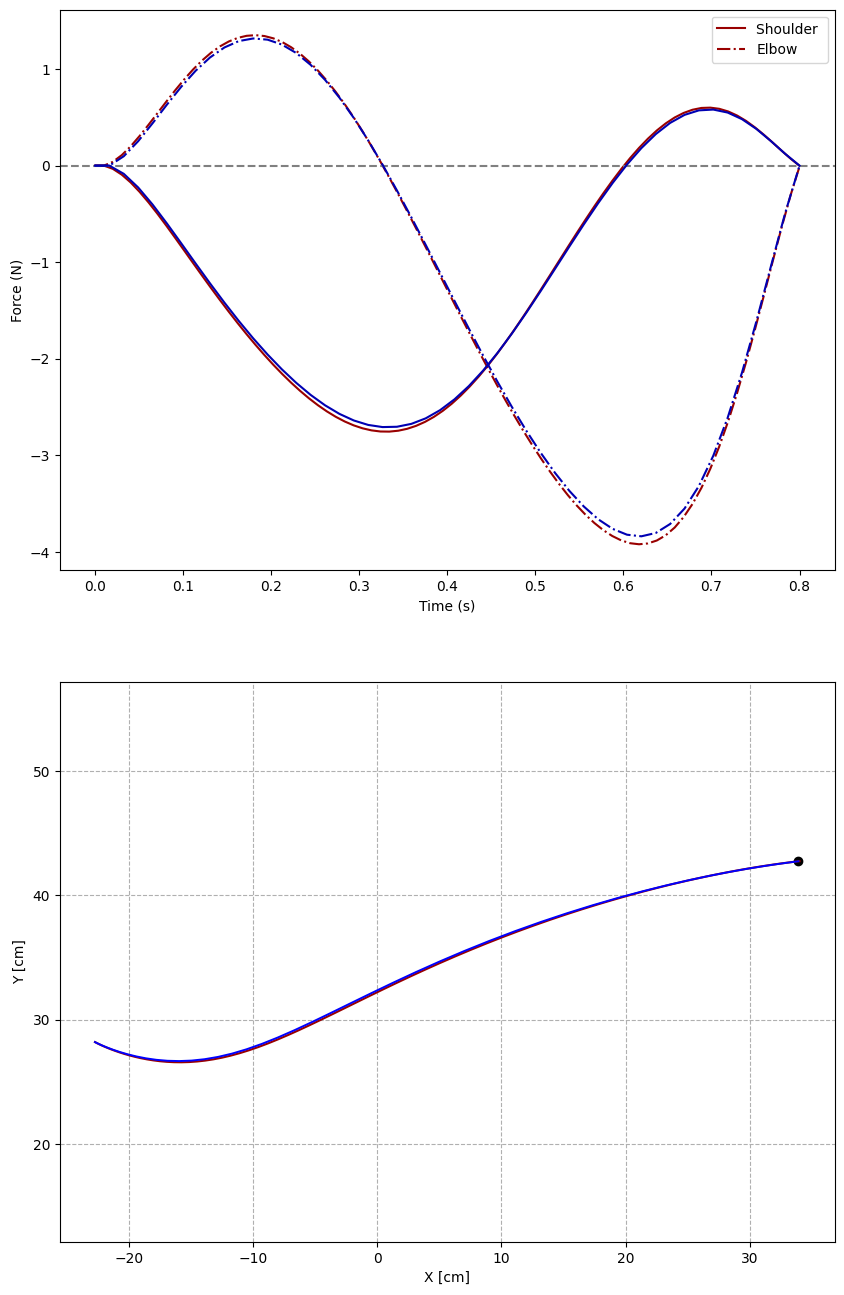

In [ ]:
targ = ToCartesian(np.array([20/180*pi,60/180*pi]))
start = ToCartesian(np.array([70/180*pi,110/180*pi]))

    # Plot results
plt.figure(figsize=(10, 16))
umpc = MPC(.8,start,targ,1e4,1,1e-4,80,dt = .01)

plt.subplot(2,1,2)
_,_,uilqg,x=ILQG(.8,1e4,1,1e-4,targ,50,start)
plt.subplot(2,1,1)
plt.plot(np.linspace(0,.8,50),x[:,2],color = "#0000b3")
plt.plot(np.linspace(0,.8,50),x[:,3],linestyle = "-.",color = "#0000b3")


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1902
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      794

Total number of variables............................:      638
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.8459914e+04 1.77e+00 8.80e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

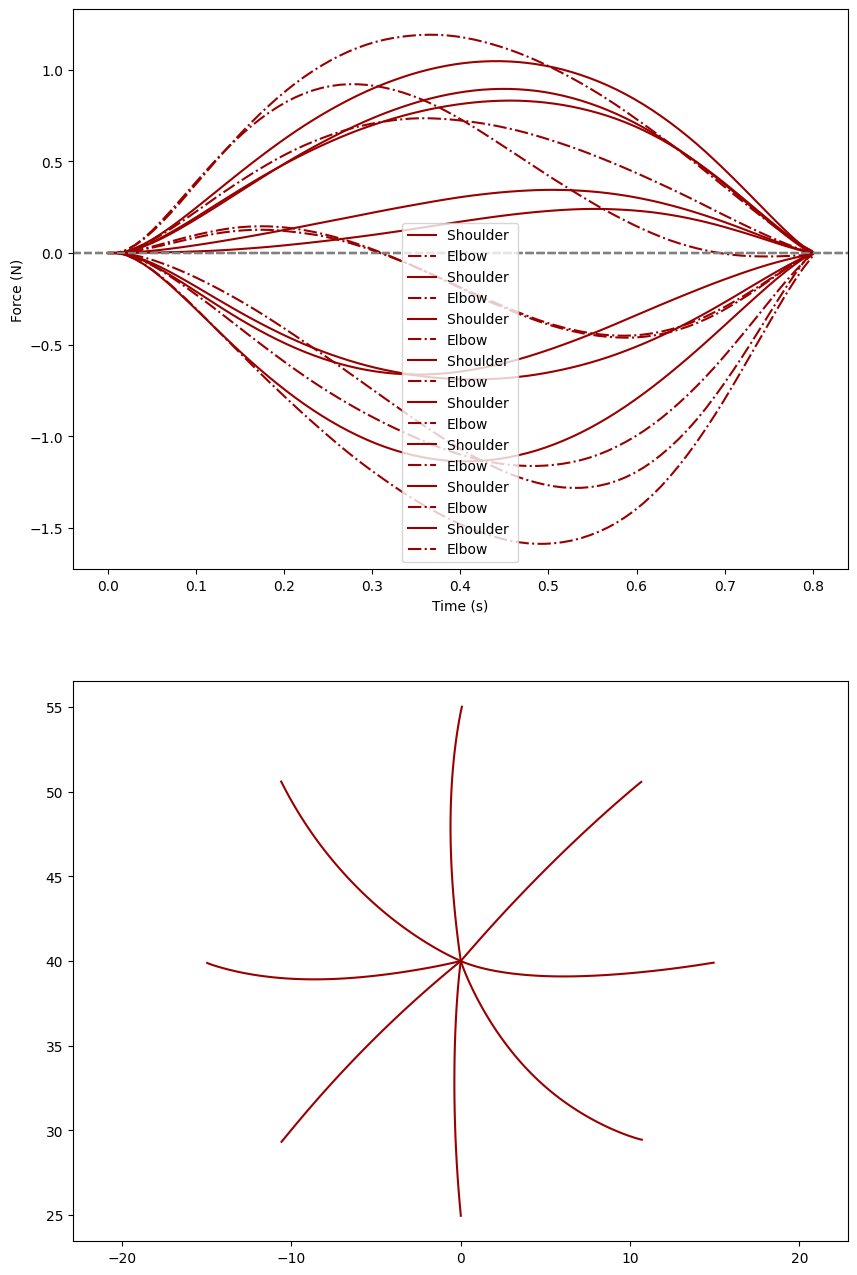

In [ ]:
start = np.array([0,40])
d = 15

    # Plot results
plt.figure(figsize=(10, 16))
for angles in np.linspace(0,2*pi,9)[:-1]:
    end = start + np.array([d*cos(angles),d*sin(angles)])
    umpc = MPC(.8,start,end,1e4,1,1e-4,80,dt = .01)

In [ ]:
I1 = 0.025
I2 = 0.045
m2 = 1
l1 = 0.3
l2 = 0.33
s2 = 0.16
K = 1/0.06
tau = 0.06

#SHOULDER PUIS ELBOW

a1 = I1 + I2 + m2*l1*l1
a2 = m2*l1*s2
a3 = I2

def optimizationofmpcproblem2(dt,Horizon,w1,w2,r,end,estimate_now):
        # State variables: x (cart position), x_dot, theta (pendulum angle), theta_dot
    theta = ca.SX.sym("theta",2,1)
    omega = ca.SX.sym("omega",2,1)
    state = ca.vertcat(theta,omega)

    # Control input: Force applied to the cart
    u = ca.SX.sym("u",6)
    control = ca.vertcat(u)

    # Equations of motion (nonlinear dynamics)
    cos_elbow = ca.cos(theta[1])
    sin_elbow = ca.sin(theta[1])
    Minv = ca.inv(ca.vertcat(
    ca.horzcat(a1+2*a2*cos_elbow, a3 +a2 * cos_elbow),
    ca.horzcat(a3 +a2 * cos_elbow, a3)
))

    C = ca.vertcat(
    -omega[1] * (2 * omega[0] + omega[1]) * a2 * sin_elbow,
    omega[0] * omega[0] * a2 * sin_elbow
) 


    

    A = ca.DM([
    [0.04, 0.04, 0, 0, 0.028, 0.028],
    [0, 0, 0.025, 0.025, 0.035, 0.035]
]).T  

    lmlo = ca.SX([0.09076,-0.02793,0.05672,0.00436,0.14294,-0.01343])
    ri = ca.SX([-0.03491,0.03491,-0.02182,0.02182,-0.05498,0.05498])
    T = ca.diag(810.8 + 1621.6 * ca.reshape(u, (6, 1)))@(-lmlo+ri*u+(A@theta))+ca.diag(54.1 + 108.1 * ca.reshape(u, (6, 1)))@(A@omega)
    #print((ca.diag(810.8 + 1621.6 * ca.reshape(u, (6, 1)))*(-lmlo+ri*u+(A@theta))).shape,(ca.diag(54.1 + 108.1 * ca.reshape(u, (6, 1)))*(A@omega)).shape)
    
    tau = -A.T@T
    
    jerk = Minv @ (tau-C)
    
    xdot = ca.vertcat(omega,jerk)

    # CasADi function for system dynamics
    f = ca.Function("f", [state, control], [xdot])

    # Define optimization variables
    opti = ca.Opti()
    X = opti.variable(4, Horizon )  # State trajectory
    U = opti.variable(6, Horizon-1)  # Control inputs

    # Initial and target states
    X0 = opti.parameter(4)
    X_targ = ca.vertcat(end[0], end[1], 0, 0)

    # Objective function and constraints
    cost = 0
    for k in range(Horizon-1):
        x_k = X[:, k]
        u_k = U[:, k]
        for l in range(6):
            cost += r[l]*u_k[l]*u_k[l]  # Quadratic cost
        
        # System dynamics constraint using Euler discretization
        x_next = X[:, k] + dt * f(x_k, u_k)
        opti.subject_to(X[:, k + 1] == x_next)

    # Final state cost
    cost += w1 * ca.sumsqr(X[:2, -1] - X_targ[:2])
    cost += w2*ca.sumsqr(X[2:4, -1] - X_targ[2:4])

    opti.minimize(cost)

    # Initial condition constraint
    opti.subject_to(X[:, 0] == X0)

    # Solver setup
    opts = {"print_time":0,'ipopt.hessian_approximation': 'exact'}
    opti.solver("ipopt",opts)
    opti.set_value(X0, estimate_now)
    sol = opti.solve()
    return sol,U,f

# Discretization parameters
def MPC2(Duration,start,end,w1,w2,r,Horizon = 20,dt = 0.005):


    

    # Simulation
    end= newton(newtonf,newtondf,1e-8,1000,end[0],end[1]) #Defini les targets
    start = newton(newtonf,newtondf,1e-8,1000,start[0],start[1])
    Duration
    n_steps = int(Duration / dt)
    states = np.zeros((4, n_steps))
    controls = np.zeros((6, n_steps-1))
    state_now = np.array([start[0], start[1],0, 0])    # Slightly off-balance initial condition
    endsteps = 0
    states[:,0] = state_now
    for t in range(n_steps-1):
        if (t+Horizon) <= n_steps : 
            sol,U,f = optimizationofmpcproblem2(dt,Horizon,w1,w2,r,end,state_now)
            
        else : endsteps +=1
        u_opt = sol.value(U[:, endsteps])
        controls[:, t] = u_opt
        # Update state using the first control action
        state_now = state_now + dt * f(state_now, u_opt).full().flatten()
        states[:, t+1] = state_now



    plt.subplot(2, 1, 1)
    plt.plot(np.linspace(0, Duration, n_steps), states[2, :], label="Shoulder ",color = "#990000")
    plt.plot(np.linspace(0, Duration, n_steps), states[3,:], label="Elbow",linestyle = "-.",color = "#990000")
    plt.axhline(0, color='grey', linestyle='--')
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.subplot(2, 1, 2)
    s = states[0]
    e = states[1]
    X = np.cos(s+e)*33+np.cos(s)*30
    Y = np.sin(s+e)*33+np.sin(s)*30
    plt.plot(X,Y,color = "#990000")
    plt.grid()
    plt.axis("equal")

    return controls

In [ ]:
I1 = 0.025
I2 = 0.045
m2 = 1
l1 = 0.3
l2 = 0.33
s2 = 0.16
K = 1/0.06
tau = 0.06

#SHOULDER PUIS ELBOW

a1 = I1 + I2 + m2*l1*l1
a2 = m2*l1*s2
a3 = I2

def optimizationofmpcproblem2bis(dt,Horizon,w1,w2,r,end,estimate_now):
        # State variables: x (cart position), x_dot, theta (pendulum angle), theta_dot
    theta = ca.SX.sym("theta",2,1)
    omega = ca.SX.sym("omega",2,1)
    T = ca.SX.sym("T",6,1)
    state = ca.vertcat(theta,omega,T)

    # Control input: Force applied to the cart
    u = ca.SX.sym("u",6)
    control = ca.vertcat(u)

    # Equations of motion (nonlinear dynamics)
    cos_elbow = ca.cos(theta[1])
    sin_elbow = ca.sin(theta[1])
    Minv = ca.inv(ca.vertcat(
    ca.horzcat(a1+2*a2*cos_elbow, a3 +a2 * cos_elbow),
    ca.horzcat(a3 +a2 * cos_elbow, a3)
))

    C = ca.vertcat(
    -omega[1] * (2 * omega[0] + omega[1]) * a2 * sin_elbow,
    omega[0] * omega[0] * a2 * sin_elbow
) 


    

    A = ca.DM([
    [0.04, 0.04, 0, 0, 0.028, 0.028],
    [0, 0, 0.025, 0.025, 0.035, 0.035]
]).T  

    Tdot = (u-T)/0.06
    tau = -A.T@T
    Bdyn = ca.SX(np.array([[0.05,0.025],[0.025,0.05]]))  
    jerk = Minv @ (tau-C-Bdyn@omega)
    
    xdot = ca.vertcat(omega,jerk,Tdot)

    # CasADi function for system dynamics
    f = ca.Function("f", [state, control], [xdot])

    # Define optimization variables
    opti = ca.Opti()
    X = opti.variable(10, Horizon )  # State trajectory
    U = opti.variable(6, Horizon-1)  # Control inputs

    # Initial and target states
    X0 = opti.parameter(10)
    X_targ = ca.vertcat(end[0], end[1], 0, 0,0,0,0,0,0,0)

    # Objective function and constraints
    cost = 0
    for k in range(Horizon-1):
        x_k = X[:, k]
        u_k = U[:, k]
        for l in range(6):
            cost += r[l]*u_k[l]*u_k[l]  # Quadratic cost
        
        # System dynamics constraint using Euler discretization
        x_next = X[:, k] + dt * f(x_k, u_k)
        opti.subject_to(X[:, k + 1] == x_next)

    # Final state cost
    cost += w1 * ca.sumsqr(X[:2, -1] - X_targ[:2])
    cost += w2*ca.sumsqr(X[2:4, -1] - X_targ[2:4])

    opti.minimize(cost)

    # Initial condition constraint
    opti.subject_to(X[:, 0] == X0)

    # Solver setup
    opts = {"print_time":0,'ipopt.hessian_approximation': 'exact'}
    opti.solver("ipopt",opts)
    opti.set_value(X0, estimate_now)
    sol = opti.solve()
    return sol,U,f

# Discretization parameters
def MPC2bis(Duration,start,end,w1,w2,r,Horizon = 20,dt = 0.005):


    

    # Simulation
    end= newton(newtonf,newtondf,1e-8,1000,end[0],end[1]) #Defini les targets
    start = newton(newtonf,newtondf,1e-8,1000,start[0],start[1])
    Duration
    n_steps = int(Duration / dt)
    states = np.zeros((10, n_steps))
    controls = np.zeros((6, n_steps-1))
    state_now = np.array([start[0], start[1],0, 0,0,0,0,0,0,0])    # Slightly off-balance initial condition
    endsteps = 0
    states[:,0] = state_now
    for t in range(n_steps-1):
        if (t+Horizon) <= n_steps : 
            sol,U,f = optimizationofmpcproblem2bis(dt,Horizon,w1,w2,r,end,state_now)
            
        else : endsteps +=1
        u_opt = sol.value(U[:, endsteps])
        controls[:, t] = u_opt
        # Update state using the first control action
        state_now = state_now + dt * f(state_now, u_opt).full().flatten()
        states[:, t+1] = state_now



    plt.subplot(2, 1, 1)
    plt.plot(np.linspace(0, Duration, n_steps), states[2, :], label="Shoulder ",color = "#007399")
    plt.plot(np.linspace(0, Duration, n_steps), states[3,:], label="Elbow",linestyle = "-.",color = "#007399")
    plt.axhline(0, color='grey', linestyle='--')
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.subplot(2, 1, 2)
    s = states[0]
    e = states[1]
    X = np.cos(s+e)*33+np.cos(s)*30
    Y = np.sin(s+e)*33+np.sin(s)*30
    plt.plot(X,Y,color = "#007399")
    plt.grid()
    plt.axis("equal")

    return controls

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2216
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2453

Total number of variables............................:      794
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      320
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.8459914e+04 2.77e+00 9.54e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

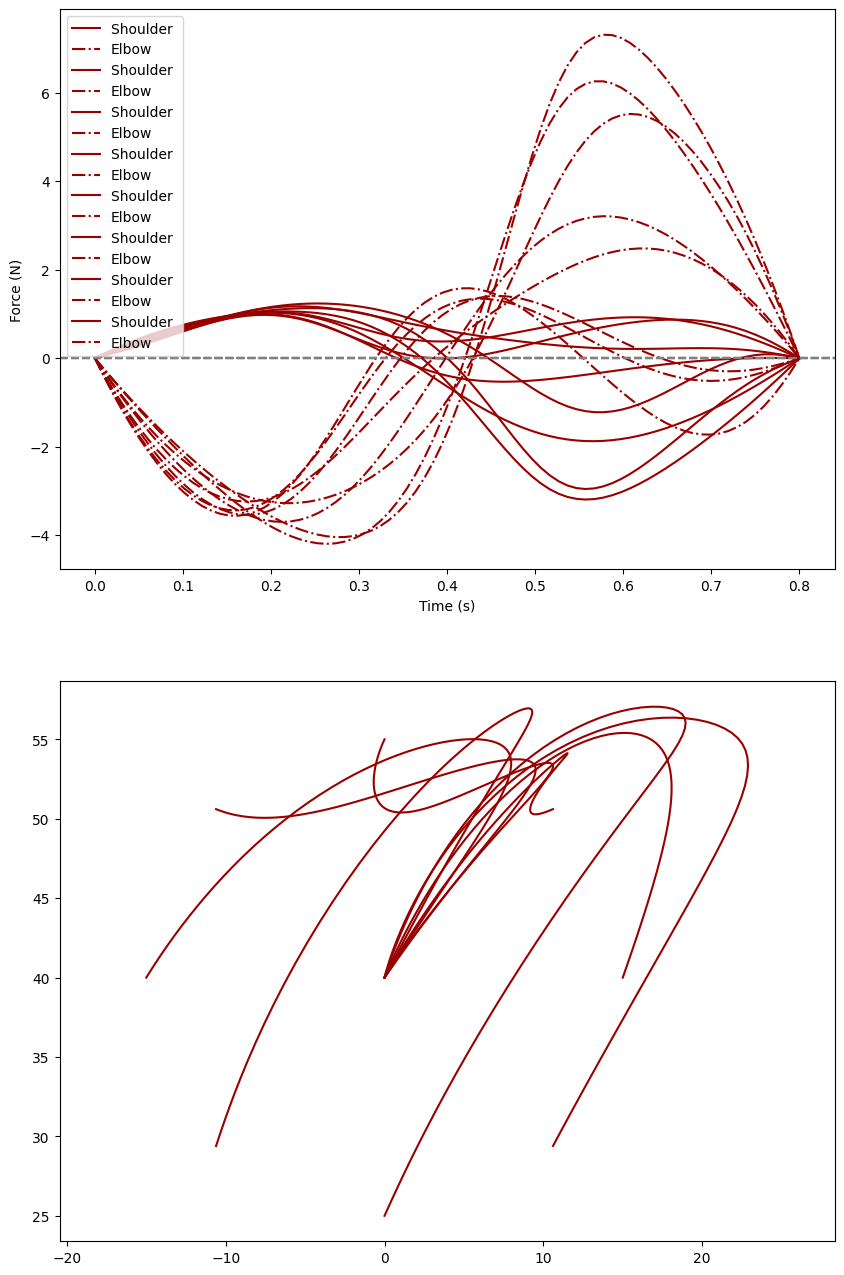

In [ ]:
start = np.array([0,40])
d = 15

    # Plot results
plt.figure(figsize=(10, 16))
for angles in np.linspace(0,2*pi,9)[:-1]:
    end = start + np.array([d*cos(angles),d*sin(angles)])
    r = [1e-4,1e-4,1e-4,1e-4,1e-4,1e-4]
    umpc = MPC2(.8,start,end,1e4,1,r,80,dt = .01)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3486
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1426

Total number of variables............................:     1274
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7711054e+04 1.72e+00 3.31e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

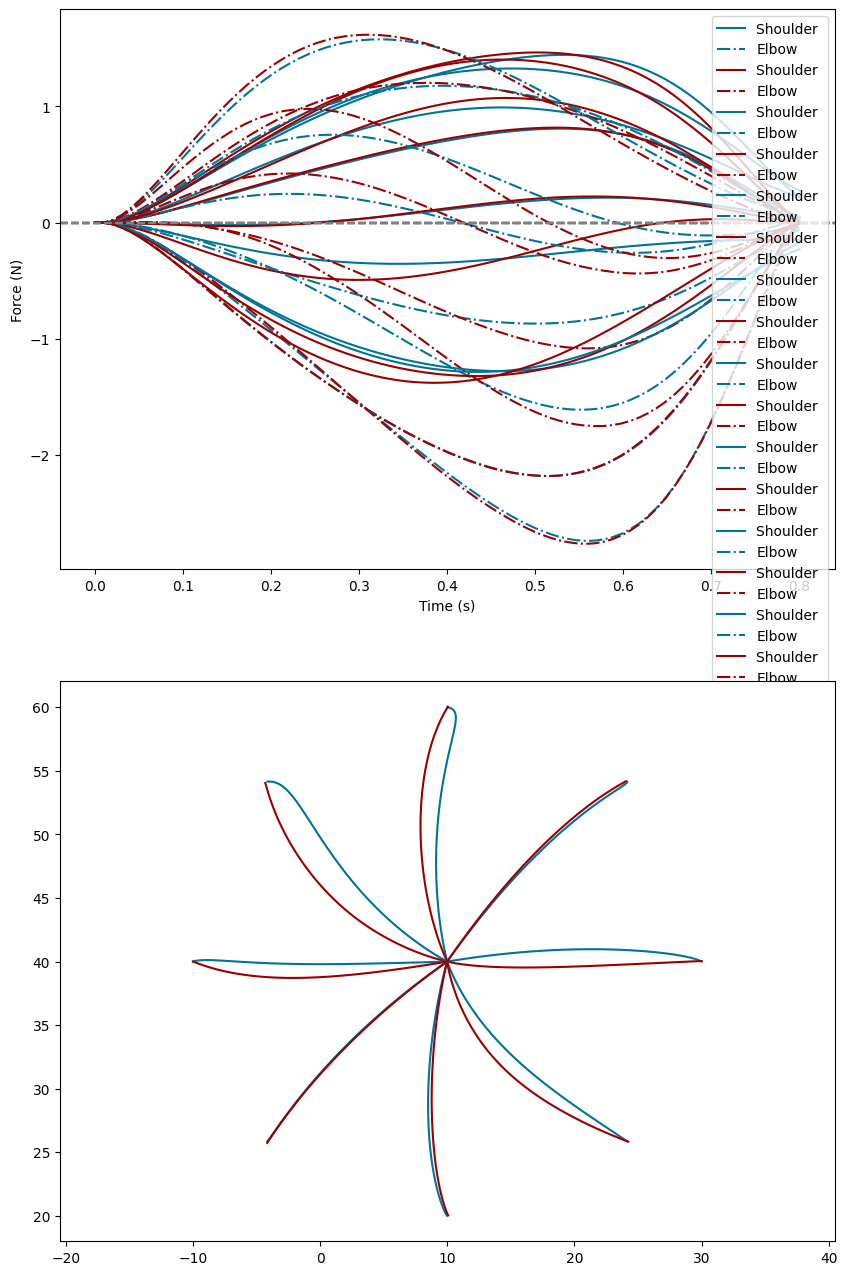

In [ ]:
start = np.array([10,40])
d = 20

    # Plot results
plt.figure(figsize=(10, 16))
for angles in np.linspace(0,2*pi,9)[:-1]:
    end = start + np.array([d*cos(angles),d*sin(angles)])
    r = [1e-4,1e-4,1e-4,1e-4,1e-4,1e-4]
    umpc = MPC2bis(.8,start,end,1e4,1,r,80,dt = .01)
    umpc = MPC(.8,start,end,1e4,1,1e-4,80,dt = .01)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1422
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      594

Total number of variables............................:      478
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0356992e+04 1.92e+00 7.93e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

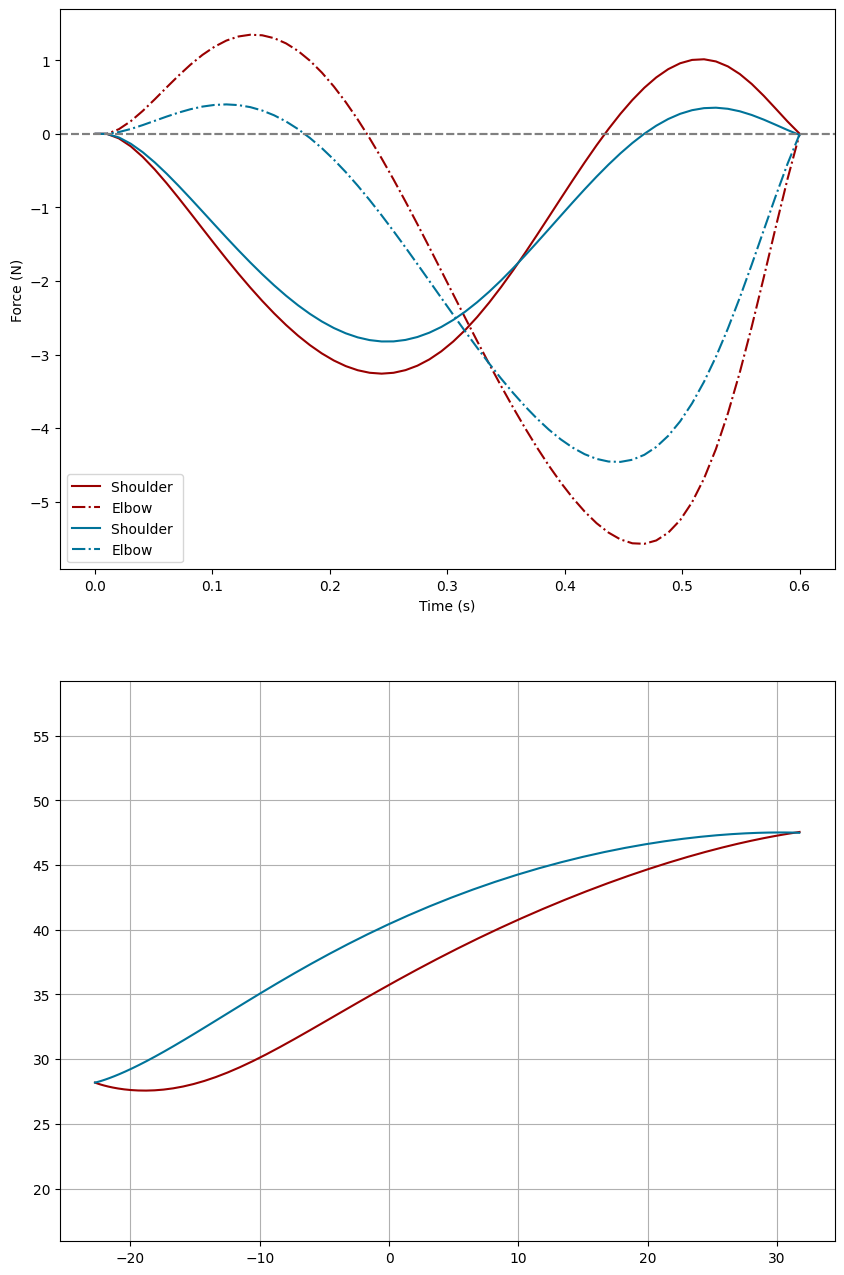

In [ ]:
targ = ToCartesian(np.array([30/180*pi,50/180*pi]))
start = ToCartesian(np.array([70/180*pi,110/180*pi]))

    # Plot results
plt.figure(figsize=(10, 16))
umpc = MPC(.6,start,targ,1e4,1,1e-6,60,dt = .01)
umpc = MPC2bis(.6,start,targ,1e4,1,np.ones(6)*1e-6,60,dt = .01)


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1422
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      594

Total number of variables............................:      478
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0766359e+04 1.22e+00 9.14e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

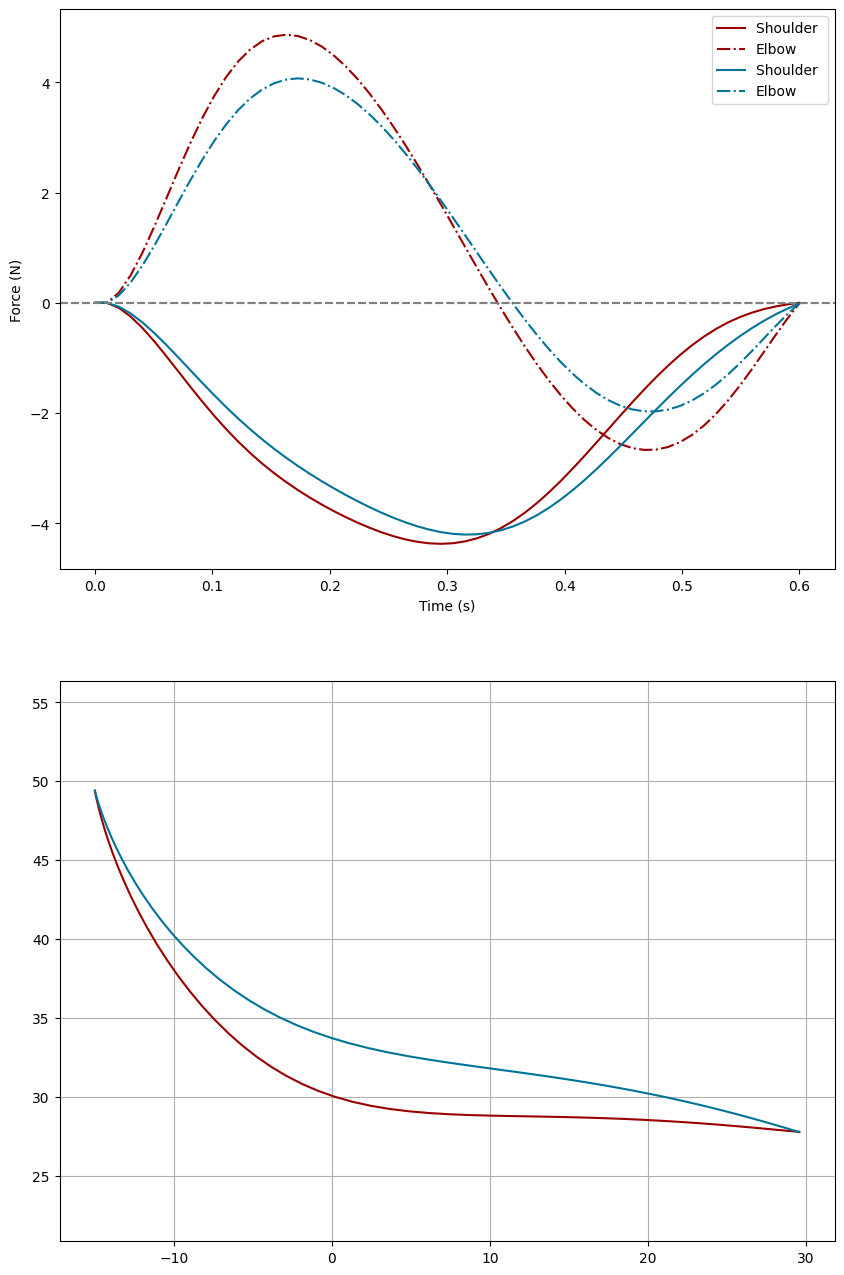

In [ ]:
targ = ToCartesian(np.array([-10/180*pi,100/180*pi]))
start = ToCartesian(np.array([70/180*pi,70/180*pi]))

    # Plot results
plt.figure(figsize=(10, 16))
umpc = MPC(.6,start,targ,1e4,1,1e-6,60,dt = .01)
umpc = MPC2bis(.6,start,targ,1e4,1,np.ones(6)*1e-6,60,dt = .01)



In [ ]:
def optimizationofmpcproblem3(dt,Horizon,w1,w2,r,end,estimate_now):
        # State variables: x (cart position), x_dot, theta (pendulum angle), theta_dot
    theta = ca.SX.sym("theta",2,1)
    omega = ca.SX.sym("omega",2,1)
    a =ca.SX.sym("a",6,1)
    state = ca.vertcat(theta,omega,a)
    a1 = ca.SX(0.0477 + 0.0588 + 0.3* 0.3*1.44)
    a2 = ca.SX(0.3 * 0.21*1.44)
    a3 = ca.SX(0.0588)

    # Control input: Force applied to the cart
    u = ca.SX.sym("u",6)
    control = ca.vertcat(u)

    # Equations of motion (nonlinear dynamics)
    cos_elbow = ca.cos(theta[1])
    sin_elbow = ca.sin(theta[1])
    Minv = ca.inv(ca.vertcat(
    ca.horzcat(a1+2*a2*cos_elbow, a3 +a2 * cos_elbow),
    ca.horzcat(a3 +a2 * cos_elbow, a3)
))

    C = ca.vertcat(
    -omega[1] * (2 * omega[0] + omega[1]) * a2 * sin_elbow,
    omega[0] * omega[0] * a2 * sin_elbow
) 
    T = A@(Fl@Vv+Fp)
    tau = M@T
    
    acc = Minv @ (tau-C-Bdyn@omega)
    filter_constant = ca.if_else(control > a, 
                     0.066 + control * (0.05 - 0.066),  # If control > state
                     0.066)
    t = ca.Function("t", [ control,a], [filter_constant])
    actuation = (u-a)/t(u,a)
    
    xdot = ca.vertcat(omega,acc,actuation)
    # CasADi function for system dynamics
    f = ca.Function("f", [state, control], [xdot])

    # Define optimization variables
    opti = ca.Opti()
    X = opti.variable(4, Horizon )  # State trajectory
    U = opti.variable(6, Horizon-1)  # Control inputs

    # Initial and target states
    X0 = opti.parameter(4)
    X_targ = ca.vertcat(end[0], end[1], 0, 0)

    # Objective function and constraints
    cost = 0
    for k in range(Horizon-1):
        x_k = X[:, k]
        u_k = U[:, k]
        cost += r*ca.sumsqr(u_k)  # Quadratic cost
        
        # System dynamics constraint using Euler discretization
        x_next = X[:, k] + dt * f(x_k, u_k)
        opti.subject_to(X[:, k + 1] == x_next)

    # Final state cost
    cost += w1 * ca.sumsqr(X[:2, -1] - X_targ[:2])
    cost += w2*ca.sumsqr(X[2:4, -1] - X_targ[2:4])

    opti.minimize(cost)

    # Initial condition constraint
    opti.subject_to(X[:, 0] == X0)

    # Solver setup
    opts = {"print_time":0,'ipopt.hessian_approximation': 'exact'}
    opti.solver("ipopt",opts)
    opti.set_value(X0, estimate_now)
    sol = opti.solve()
    return sol,U,f

# Discretization parameters
def MPC3(Duration,start,end,w1,w2,r,Horizon = 20,dt = 0.005):


    

    # Simulation
    Duration
    n_steps = int(Duration / dt)
    states = np.zeros((4, n_steps))
    controls = np.zeros((6, n_steps-1))
    state_now = np.array([start[0], start[1],0, 0])    # Slightly off-balance initial condition
    endsteps = 0
    states[:,0] = state_now
    for t in range(n_steps-1):
        if (t+Horizon) <= n_steps : 
            sol,U,f = optimizationofmpcproblem3(dt,Horizon,w1,w2,r,end,state_now)
            
        else : endsteps +=1
        u_opt = sol.value(U[:, endsteps])
        controls[:, t] = u_opt
        # Update state using the first control action
        state_now = state_now + dt * f(state_now, u_opt).full().flatten()
        states[:, t+1] = state_now

    # Plot results
    plt.figure(figsize=(10, 16))

    plt.subplot(2, 1, 1)
    plt.plot(np.linspace(0, Duration, n_steps), states[2, :], label="Shoulder ",color = "#990000")
    plt.plot(np.linspace(0, Duration, n_steps), states[3,:], label="Elbow",linestyle = "-.",color = "#990000")
    plt.axhline(0, color='grey', linestyle='--')
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.subplot(2, 1, 2)
    s = states[0]
    e = states[1]
    X = np.cos(s+e)*35+np.cos(s)*30
    Y = np.sin(s+e)*35+np.sin(s)*30
    plt.plot(X,Y,color = "#990000")
    plt.grid()
    plt.axis("equal")

    return controls

In [ ]:
I1 = 0.025
I2 = 0.045
m2 = 1
l1 = 0.3
l2 = 0.33
s2 = 0.16
K = 1/0.06
tau = 0.06

#SHOULDER PUIS ELBOW

a1 = I1 + I2 + m2*l1*l1
a2 = m2*l1*s2
a3 = I2

def optimizationofmpcproblem4(dt,Horizon,w1,w2,r,end,estimate_now):
        # State variables: x (cart position), x_dot, theta (pendulum angle), theta_dot
    theta = ca.SX.sym("theta",2,1)
    omega = ca.SX.sym("omega",2,1)
    a = ca.SX.sym("a",6,1)
    state = ca.vertcat(theta,omega,a)

    # Control input: Force applied to the cart
    u = ca.SX.sym("u",6)
    control = ca.vertcat(u)

    # Equations of motion (nonlinear dynamics)
    cos_elbow = ca.cos(theta[1])
    sin_elbow = ca.sin(theta[1])
    Minv = ca.inv(ca.vertcat(
    ca.horzcat(a1+2*a2*cos_elbow, a3 +a2 * cos_elbow),
    ca.horzcat(a3 +a2 * cos_elbow, a3)
))

    C = ca.vertcat(
    -omega[1] * (2 * omega[0] + omega[1]) * a2 * sin_elbow,
    omega[0] * omega[0] * a2 * sin_elbow
) 


    

    M = ca.DM([
    [0.04, 0.04, 0, 0, 0.028, 0.028],
    [0, 0, 0.025, 0.025, 0.035, 0.035]
]).T  
    lrest = ca.SX([0.09, 0.04, 0.06, 0.1, 0.19, 0.14])
    Fmax = ca.SX([1142, 260, 987, 624, 430, 798])
    vmax = 6.28*lrest
    adot = (u-a)/0.06
    l = lrest-M@theta
    v = -M@omega
    Vsh = .3
    fl = ca.exp(-(((l-lrest)/lrest)/.5)**2)
    fv = Vsh*(vmax+v)/(Vsh*vmax-v)

    

    T = a*fl*fv*Fmax
    tau = -M.T@T
    Bdyn = ca.SX(np.array([[0.05,0.025],[0.025,0.05]]))  
    acc = Minv @ (tau-C-Bdyn@omega)
    
    xdot = ca.vertcat(omega,acc,adot)

    # CasADi function for system dynamics
    f = ca.Function("f", [state, control], [xdot])

    # Define optimization variables
    opti = ca.Opti()
    X = opti.variable(10, Horizon )  # State trajectory
    U = opti.variable(6, Horizon-1)  # Control inputs

    # Initial and target states
    X0 = opti.parameter(10)
    X_targ = ca.vertcat(end[0], end[1], 0, 0,0,0,0,0,0,0)

    # Objective function and constraints
    cost = 0
    for k in range(Horizon-1):
        x_k = X[:, k]
        u_k = U[:, k]
        for l in range(6):
            cost += r[l]*u_k[l]*u_k[l]  # Quadratic cost
        
        # System dynamics constraint using Euler discretization
        x_next = X[:, k] + dt * f(x_k, u_k)
        opti.subject_to(X[:, k + 1] == x_next)

    # Final state cost
    cost += w1 * ca.sumsqr(X[:2, -1] - X_targ[:2])
    cost += w2*ca.sumsqr(X[2:4, -1] - X_targ[2:4])

    opti.minimize(cost)

    # Initial condition constraint
    opti.subject_to(X[:, 0] == X0)

    # Solver setup
    opts = {'ipopt.print_level': 0,
    "print_time": 0,
    "ipopt.hessian_approximation": "exact",
    "ipopt.tol": 1e-13,                      # Decrease tolerance for better precision
    "ipopt.acceptable_tol": 1e-8,           # More stringent acceptable tolerance
    "ipopt.max_iter": 5000,                 # Increase max iterations
    "ipopt.constr_viol_tol": 1e-9,          # Constraint violation tolerance
    "ipopt.dual_inf_tol": 1e-8,             # Dual infeasibility tolerance
    "ipopt.compl_inf_tol": 1e-8             # Complementarity tolerance
    }
    opti.solver("ipopt",opts)
    opti.set_value(X0, estimate_now)
    sol = opti.solve()
    return sol,U,f

# Discretization parameters
def MPC4(Duration,start,end,w1,w2,r,Horizon = 20,dt = 0.005):


    

    # Simulation
    end_angular= newton(newtonf,newtondf,1e-8,1000,end[0],end[1]) #Defini les targets
    start = newton(newtonf,newtondf,1e-8,1000,start[0],start[1])
    Duration
    n_steps = int(Duration / dt)
    states = np.zeros((10, n_steps))
    controls = np.zeros((6, n_steps-1))
    state_now = np.array([start[0], start[1],0, 0,0,0,0,0,0,0])    # Slightly off-balance initial condition
    endsteps = 0
    states[:,0] = state_now
    for t in range(n_steps-1):
        if (t+Horizon) <= n_steps : 
            sol,U,f = optimizationofmpcproblem4(dt,Horizon,w1,w2,r,end_angular,state_now)
            
        else : endsteps +=1
        u_opt = sol.value(U[:, endsteps])
        controls[:, t] = u_opt
        # Update state using the first control action
        state_now = state_now + dt * f(state_now, u_opt).full().flatten()
        states[:, t+1] = state_now



    plt.subplot(2, 1, 1)
    plt.plot(np.linspace(0, Duration, n_steps), states[2, :], label="Shoulder ",color = "#007399")
    plt.plot(np.linspace(0, Duration, n_steps), states[3,:], label="Elbow",linestyle = "-.",color = "#007399")
    plt.axhline(0, color='grey', linestyle='--')
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.subplot(2, 1, 2)
    s = states[0]
    e = states[1]
    X = np.cos(s+e)*33+np.cos(s)*30
    Y = np.sin(s+e)*33+np.sin(s)*30
    plt.plot(X,Y,color = "#007399")
    plt.grid()
    plt.axis("equal")
    plt.scatter([end[0]],[end[1]],color = "red")
    return controls

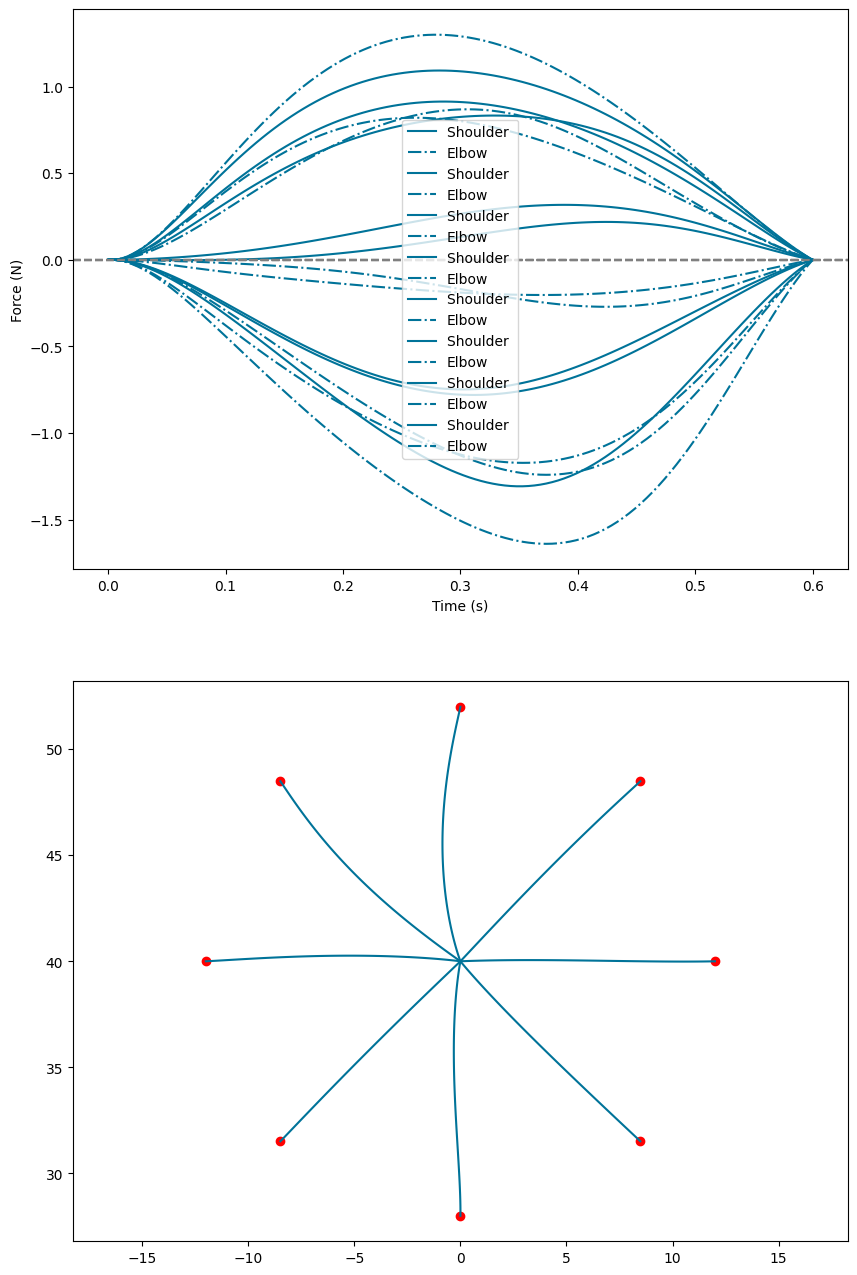

In [ ]:
start = np.array([0,40])
d = 12

    # Plot results
plt.figure(figsize=(10, 16))
for angles in np.linspace(0,2*pi,9)[:-1]:
    end = start + np.array([d*cos(angles),d*sin(angles)])
    
    r = np.ones(6)*1e-4
    umpc = MPC4(.6,start,end,1e4,1,r,120,dt = .005)

In [ ]:
def optimizationofmpcproblem42(dt,Horizon,w1,w2,r,end,estimate_now):
        # State variables: x (cart position), x_dot, theta (pendulum angle), theta_dot
    theta = ca.SX.sym("theta",2,1)
    omega = ca.SX.sym("omega",2,1)
    a = ca.SX.sym("a",6,1)
    state = ca.vertcat(theta,omega,a)

    # Control input: Force applied to the cart
    u = ca.SX.sym("u",6)
    control = ca.vertcat(u)

    # Equations of motion (nonlinear dynamics)
    cos_elbow = ca.cos(theta[1])
    sin_elbow = ca.sin(theta[1])
    Minv = ca.inv(ca.vertcat(
    ca.horzcat(a1+2*a2*cos_elbow, a3 +a2 * cos_elbow),
    ca.horzcat(a3 +a2 * cos_elbow, a3)
))

    C = ca.vertcat(
    -omega[1] * (2 * omega[0] + omega[1]) * a2 * sin_elbow,
    omega[0] * omega[0] * a2 * sin_elbow
) 


    

    M = ca.DM([
    [0.04, 0.04, 0, 0, 0.028, 0.028],
    [0, 0, 0.025, 0.025, 0.035, 0.035]
]).T  
    lrest = ca.SX([0.09, 0.04, 0.06, 0.1, 0.19, 0.14])
    Fmax = ca.SX([1142, 260, 987, 624, 430, 798])
    vmax = 6.28*lrest
    adot = (u-a)/0.06
    l = lrest-M@theta
    v = -M@omega
    Vsh = .3
    fl = ca.exp(-(((l-lrest)/lrest)/.5)**2)
    fv = (vmax-v)/(vmax+.3*v)

    

    T = a*fl*fv*Fmax
    tau = -M.T@T
    Bdyn = ca.SX(np.array([[0.05,0.025],[0.025,0.05]]))  
    acc = Minv @ (tau-C-Bdyn@omega)
    
    xdot = ca.vertcat(omega,acc,adot)

    # CasADi function for system dynamics
    f = ca.Function("f", [state, control], [xdot])

    # Define optimization variables
    opti = ca.Opti()
    X = opti.variable(10, Horizon )  # State trajectory
    U = opti.variable(6, Horizon-1)  # Control inputs

    # Initial and target states
    X0 = opti.parameter(10)
    X_targ = ca.vertcat(end[0], end[1], 0.0, 0,0,0,0,0,0,0)

    # Objective function and constraints
    cost = 0
    for k in range(Horizon-1):
        x_k = X[:, k]
        u_k = U[:, k]
        for l in range(6):
            cost += r[l]*u_k[l]*u_k[l]  # Quadratic cost
        
        # System dynamics constraint using Euler discretization
        x_next = X[:, k] + dt * f(x_k, u_k)
        opti.subject_to(X[:, k + 1] == x_next)

    # Final state cost
    cost += w1 * ca.sumsqr(X[:2, -1] - X_targ[:2])
    cost += w2*ca.sumsqr(X[2:4, -1] - X_targ[2:4])

    opti.minimize(cost)

    # Initial condition constraint
    opti.subject_to(X[:, 0] == X0)

    # Solver setup
    opts = {'ipopt.print_level': 0,
    "print_time": 0,
    "ipopt.tol": 1e-10,                      # Decrease tolerance for better precision
    "ipopt.acceptable_tol": 1e-12,           # More stringent acceptable tolerance
    "ipopt.max_iter": 5000,                 # Increase max iterations          # Constraint violation tolerance            # Complementarity tolerance
    }
    opti.solver("ipopt",opts)
    opti.set_value(X0, estimate_now)
    sol = opti.solve()
    return sol,U,f

def MPC42(Duration,start,end,w1,w2,r,Horizon = 20,dt = 0.005,stepupdate = 5):


    

    # Simulation
    end_angular= newton(newtonf,newtondf,1e-8,1000,end[0],end[1]) #Defini les targets
    start = newton(newtonf,newtondf,1e-8,1000,start[0],start[1])
    Duration
    n_steps = int(Duration / dt)
    states = np.zeros((10, n_steps))
    controls = np.zeros((6, n_steps-1))
    state_now = np.array([start[0], start[1],0,0,0,0,0,0,0,0])    # Slightly off-balance initial condition
    states[:,0] = state_now
    ecart = -stepupdate
    for t in range(n_steps-1):
        if t%stepupdate ==0: 
            ecart +=stepupdate
            sol,U,f = optimizationofmpcproblem42(dt,Horizon-ecart,w1,w2,r,end_angular,state_now)
    
        u_opt = sol.value(U[:, t-ecart])
        controls[:, t] = u_opt
        # Update state using the first control action
        state_now = state_now + dt * f(state_now, u_opt).full().flatten()
        states[:, t+1] = state_now



    plt.subplot(2, 1, 1)
    plt.plot(np.linspace(0, Duration, n_steps), states[2, :], label="Shoulder ",color = "#007399")
    plt.plot(np.linspace(0, Duration, n_steps), states[3,:], label="Elbow",linestyle = "-.",color = "#007399")
    plt.axhline(0, color='grey', linestyle='--')
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.subplot(2, 1, 2)
    s = states[0]
    e = states[1]
    X = np.cos(s+e)*33+np.cos(s)*30
    Y = np.sin(s+e)*33+np.sin(s)*30
    plt.plot(X,Y,color = "#007399")
    plt.grid()
    plt.axis("equal")
    plt.scatter([end[0]],[end[1]],color = "red")
    return controls

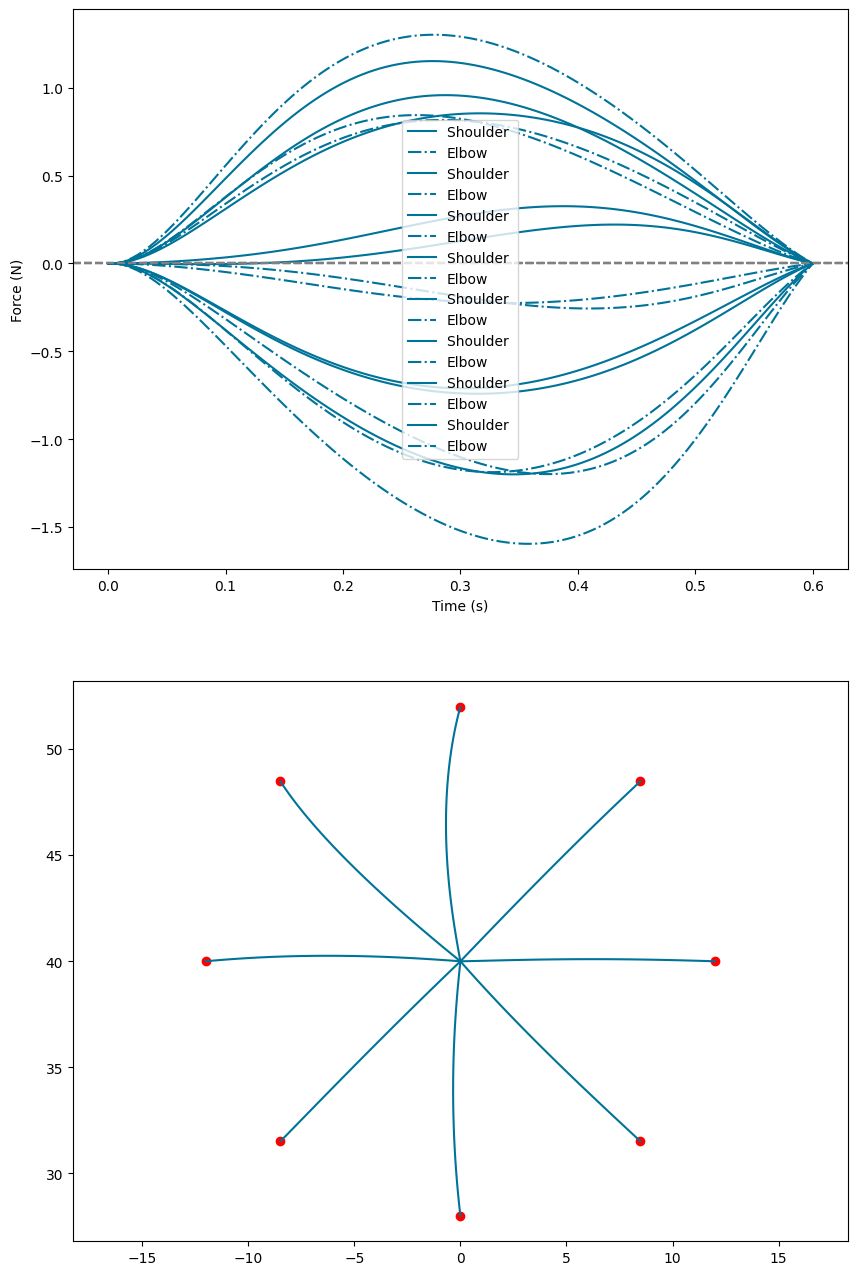

In [ ]:
start = np.array([0,40])
d = 12

    # Plot results
plt.figure(figsize=(10, 16))
for angles in np.linspace(0,2*pi,9)[:-1]:
    end = start + np.array([d*cos(angles),d*sin(angles)])
    
    r = np.ones(6)*1e-4
    umpc = MPC42(.6,start,end,1e4,1,r,120,dt = .005)

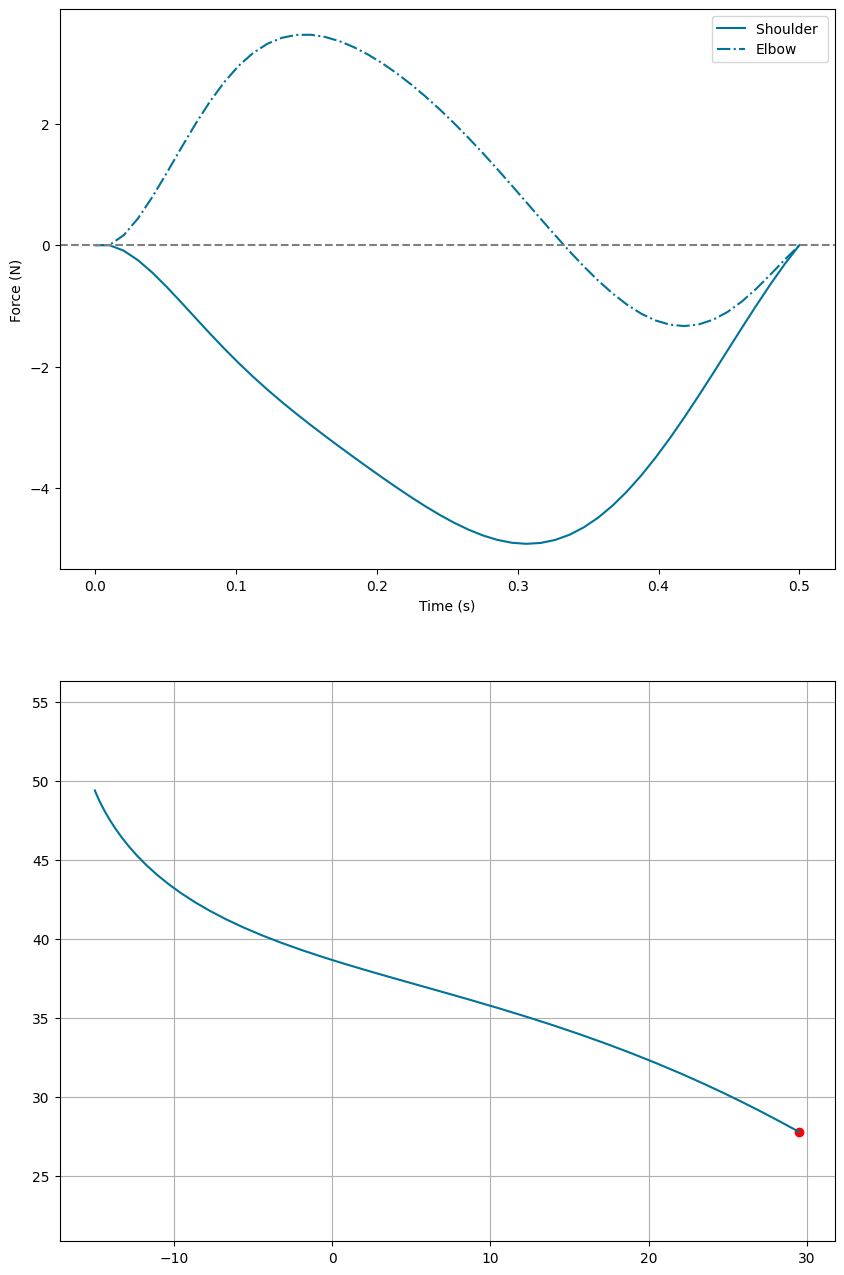

In [ ]:
plt.figure(figsize=(10, 16))

end = ToCartesian(np.array([-10/180*pi,100/180*pi]))
start = ToCartesian(np.array([70/180*pi,70/180*pi]))
    
r = np.ones(6)*1e-4
umpc = MPC42(.5,start,end,1e4,1,r,50,dt = .01,stepupdate =50)

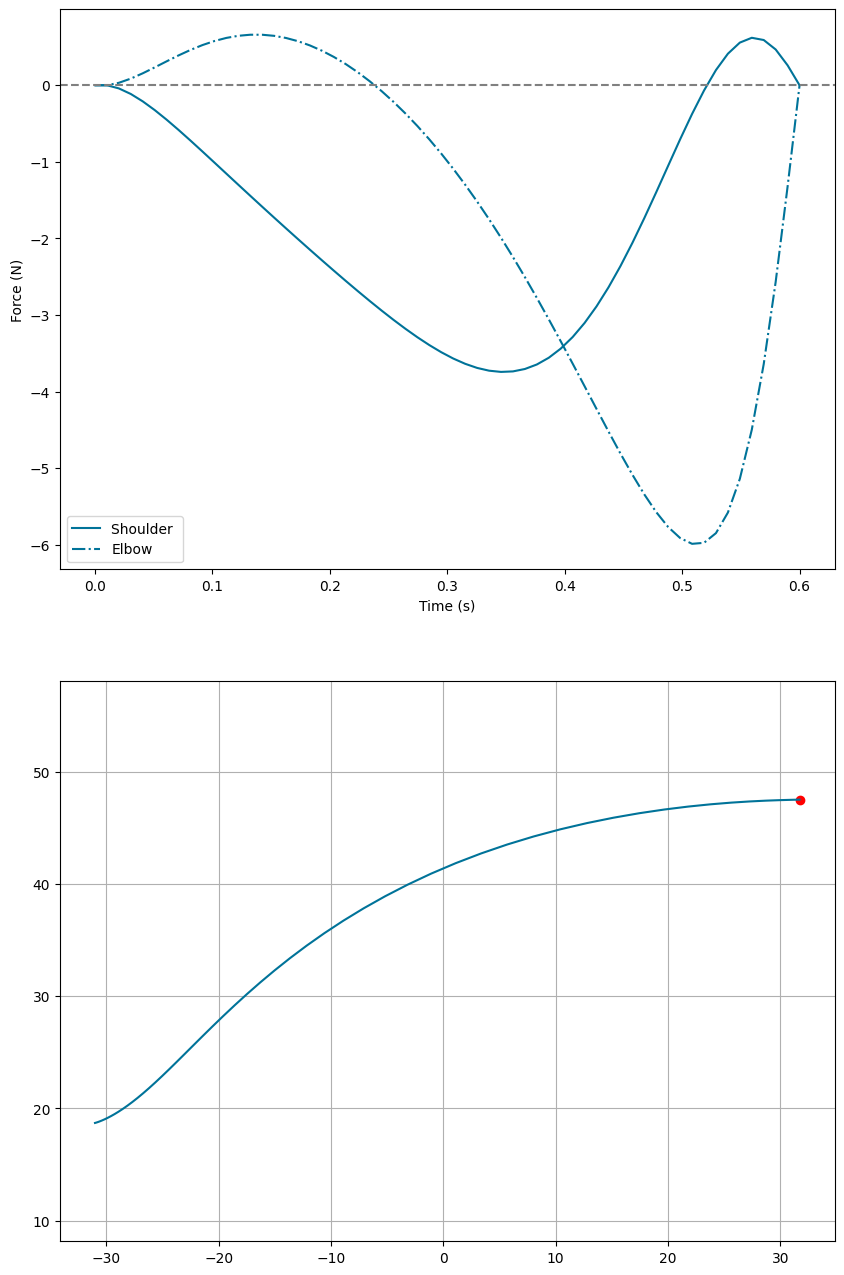

In [ ]:
plt.figure(figsize=(10, 16))

end = ToCartesian(np.array([30/180*pi,50/180*pi]))
start = ToCartesian(np.array([90/180*pi,110/180*pi]))
    
r = np.ones(6)*1e-4
umpc = MPC42(.6,start,end,1e4,1,r,60,dt = .01,stepupdate =40)

In [ ]:
print(31.8*np.array([18,14,22,12,5,10]))

[572.4 445.2 699.6 381.6 159.  318. ]


l is [1.07819, 0.339021, 0.851915, 1.01772, 1.06463, 1.15513]

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Solver did not find a solution.
[1.07819, 0.339021, 0.851915, 1.01772, 1.06463, 1.15513]
[1.07819, 0.339021, 0.851915, 1.01772, 1.06463, 1.15513]
[1.0782, 0.338964, 0.851936, 1.01771, 1.06469, 1.15509]
[1.07826, 0.338768, 0.851932, 1.01771, 1.06475, 1.15504]
[1.07835, 0.338434, 0.851864, 1.01776, 1.06479, 1.15503]
[1.07848, 0.337976, 0.851706, 1.01788, 1.06475, 1.15511]
[1.07863, 0.33741, 0.851443, 1.01809, 1.0646, 1.15529]
[1.07882, 0.336746, 0.85107, 1.01837, 1.06434, 1.15557]
[1.07903, 0.335995, 0.85059, 1.01874, 1.06396, 1.15597]
[1.07926, 0

CasADi - 2025-04-08 11:20:36 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 192, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-04-08 11:20:36 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 242, col 0).") [.../casadi/core/oracle_function.cpp:393]


Solver did not find a solution.
[1.07819, 0.339021, 0.851915, 1.01772, 1.06463, 1.15513]
[1.07819, 0.339021, 0.851915, 1.01772, 1.06463, 1.15513]
[1.07821, 0.338957, 0.851838, 1.01778, 1.06455, 1.15521]
[1.07825, 0.338786, 0.851627, 1.01794, 1.06432, 1.15543]
[1.07834, 0.338475, 0.851247, 1.01824, 1.06392, 1.15582]
[1.07847, 0.338005, 0.850675, 1.01867, 1.0633, 1.15642]
[1.07865, 0.337366, 0.849901, 1.01927, 1.06248, 1.15722]
[1.07887, 0.336555, 0.848924, 1.02002, 1.06143, 1.15823]
[1.07914, 0.335577, 0.847752, 1.02092, 1.06018, 1.15944]
[1.07946, 0.334441, 0.846398, 1.02196, 1.05874, 1.16084]
[1.07981, 0.333161, 0.84488, 1.02312, 1.05712, 1.1624]
[1.0802, 0.331752, 0.843218, 1.0244, 1.05536, 1.16411]
[1.08062, 0.330233, 0.841438, 1.02576, 1.05347, 1.16594]
[1.08106, 0.328626, 0.839566, 1.0272, 1.05149, 1.16786]
[1.08153, 0.32695, 0.837627, 1.02869, 1.04945, 1.16985]
[1.082, 0.325228, 0.835651, 1.0302, 1.04737, 1.17187]
[1.08249, 0.323482, 0.833663, 1.03173, 1.04528, 1.1739]
[1.08297, 

CasADi - 2025-04-08 11:20:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 52, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-04-08 11:20:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 252, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-04-08 11:20:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 102, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-04-08 11:20:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 142, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-04-08 11:20:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 202, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-04-08 11:20:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 292, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-04-08 11:20:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 5

Solver did not find a solution.
[1.07819, 0.339021, 0.851915, 1.01772, 1.06463, 1.15513]
[1.07819, 0.339021, 0.851915, 1.01772, 1.06463, 1.15513]
[1.07819, 0.339011, 0.851911, 1.01773, 1.06463, 1.15513]
[1.0782, 0.338984, 0.851898, 1.01774, 1.06462, 1.15514]
[1.07821, 0.338935, 0.851874, 1.01775, 1.06461, 1.15516]
[1.07823, 0.338867, 0.851838, 1.01778, 1.06459, 1.15519]
[1.07825, 0.338787, 0.85179, 1.01782, 1.06455, 1.15522]
[1.07828, 0.338703, 0.851731, 1.01786, 1.0645, 1.15528]
[1.0783, 0.338625, 0.851661, 1.01792, 1.06443, 1.15534]
[1.07832, 0.338561, 0.851582, 1.01798, 1.06435, 1.15542]
[1.07833, 0.338512, 0.851494, 1.01805, 1.06425, 1.15552]
[1.07834, 0.338471, 0.851395, 1.01812, 1.06412, 1.15564]
[1.07835, 0.338431, 0.851284, 1.01821, 1.06399, 1.15576]
[1.07836, 0.338382, 0.85116, 1.0183, 1.06383, 1.15591]
[1.07838, 0.338315, 0.851019, 1.01841, 1.06366, 1.15607]
[1.07841, 0.338221, 0.850863, 1.01853, 1.06348, 1.15624]
[1.07844, 0.338094, 0.850689, 1.01866, 1.06329, 1.15642]
[1.07

CasADi - 2025-04-08 11:20:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 182, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-04-08 11:20:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 232, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-04-08 11:20:38 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 462, col 0).") [.../casadi/core/oracle_function.cpp:393]


Solver did not find a solution.
[1.07819, 0.339021, 0.851915, 1.01772, 1.06463, 1.15513]
[1.07819, 0.339021, 0.851915, 1.01772, 1.06463, 1.15513]
[1.07817, 0.339072, 0.852033, 1.01763, 1.06478, 1.155]
[1.07813, 0.339242, 0.852329, 1.01741, 1.06512, 1.15467]
[1.07804, 0.339545, 0.852809, 1.01704, 1.06567, 1.15415]
[1.07793, 0.33997, 0.853447, 1.01655, 1.0664, 1.15346]
[1.07778, 0.34049, 0.854199, 1.01597, 1.06724, 1.15265]
[1.07762, 0.341066, 0.85501, 1.01535, 1.06814, 1.15179]
[1.07746, 0.341653, 0.855826, 1.01472, 1.06905, 1.15092]
[1.07731, 0.342204, 0.856588, 1.01414, 1.0699, 1.15011]
[1.07718, 0.342673, 0.857247, 1.01363, 1.07063, 1.14941]
[1.07708, 0.343022, 0.857754, 1.01324, 1.0712, 1.14886]
[1.07703, 0.343217, 0.858076, 1.013, 1.07157, 1.14851]
[1.07702, 0.343236, 0.85819, 1.01291, 1.07172, 1.14837]
[1.07707, 0.343068, 0.858095, 1.01298, 1.07166, 1.14844]
[1.07716, 0.342719, 0.857813, 1.0132, 1.0714, 1.1487]
[1.0773, 0.34222, 0.857386, 1.01353, 1.071, 1.14911]
[1.07747, 0.34162

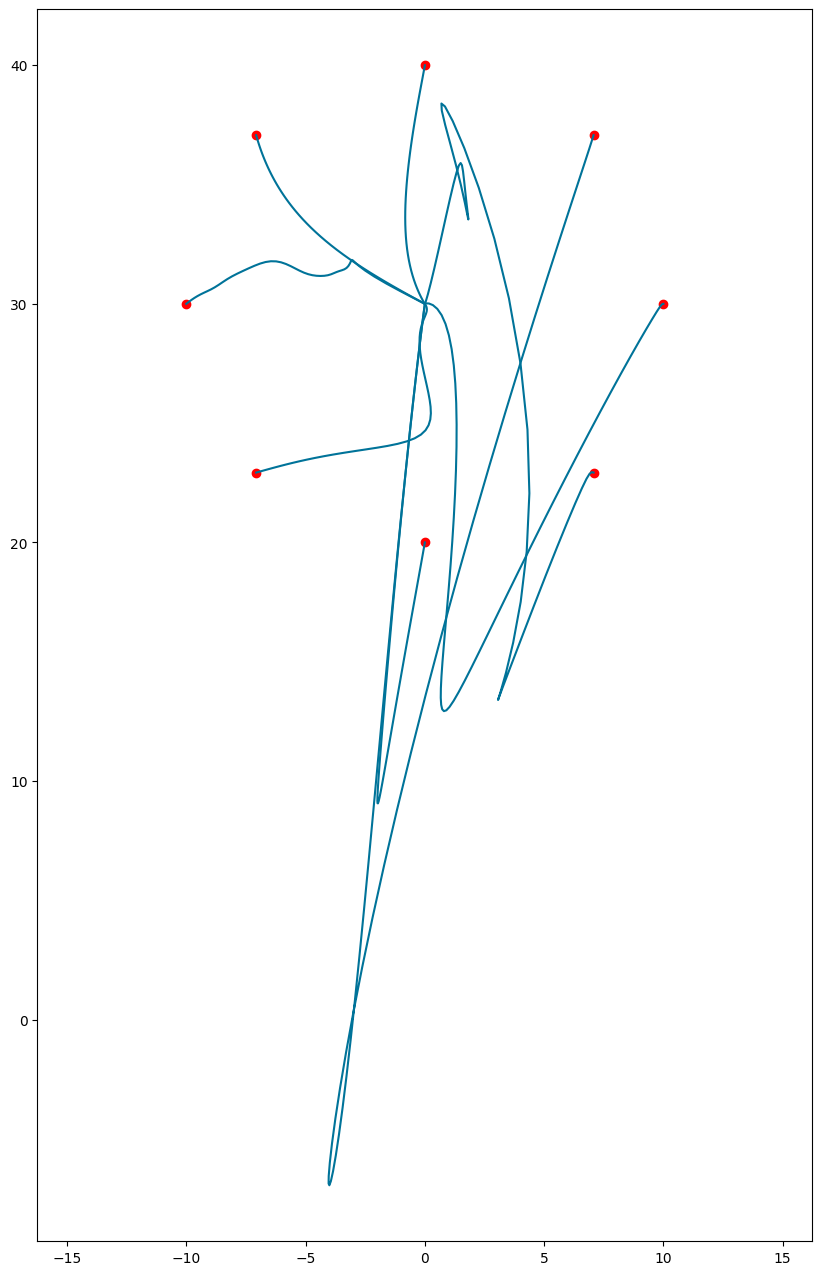

In [1]:

import sys
sys.path.append('..')

import matplotlib.pyplot as plt
from Helpers.Helpers import *
from Controllers.NMPC import *

start = np.array([0,30])
d = 10

    # Plot results
plt.figure(figsize=(10, 16))
for angles in np.linspace(0,2*pi,9)[:-1]:
    end = start + np.array([d*cos(angles),d*sin(angles)])

    sol = MPCTodorov(.6,start,end,n_steps=60,r = 1e-4,stepupdate=60)
    #for i in range(6):print(np.max(np.abs(sol[4+i])))

Solver did not find a solution.
Solver did not find a solution.


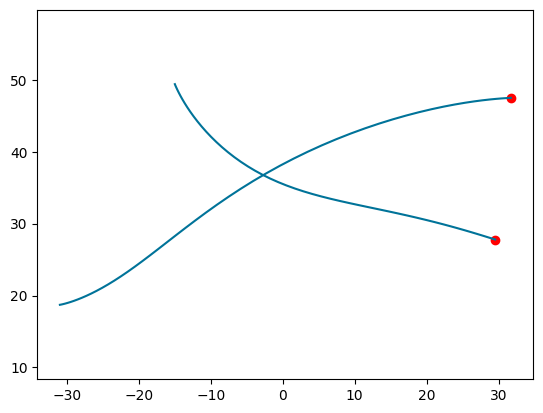

In [3]:

end = ToCartesian(np.array([30/180*pi,50/180*pi]))
start = ToCartesian(np.array([90/180*pi,110/180*pi]))
    
r = np.ones(6)*1e-4
umpc = MPCTodorov(.6,start,end,1e4,1,r,60,stepupdate =60)


end = ToCartesian(np.array([-10/180*pi,100/180*pi]))
start = ToCartesian(np.array([70/180*pi,70/180*pi]))
umpc = MPCTodorov(.6,start,end,1e4,1,r,60,stepupdate =60)
